In [ ]:
%%capture
!git clone https://github.com/uakarsh/sample_rvl_cdip_dataset.git
!pip install pytesseract
!sudo apt install tesseract-ocr
!pip install transformers
!pip install 'Pillow==7.1.2'
!pip install pytorch_lightning

In [ ]:
import pandas as pd
import os
from PIL import Image, ImageDraw
from transformers import RobertaTokenizer
from dataset import create_features
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

In [ ]:
## Utility function for plotting the OCR detected on the document

def plot_ocr_on_image(img, bounding_box):
  draw = ImageDraw.Draw(img)  
  
  for curr_box in bounding_box:
    curr_box = tuple(curr_box)
    x0, x1, y0, y1, width, height = curr_box
    draw.rectangle(xy = [(x0, y0), (x1, y1)], outline = 'purple')
  
  return img

## Making the Dataset

In [ ]:
class NewDataset(Dataset):

  def __init__(self, dataframe : pd.DataFrame, tokenizer,
               max_seq_length : int = 512,
              size : int = 1000):
    
    self.dataframe = dataframe
    self.tokenizer = tokenizer
    self.max_seq_length = max_seq_length
    self.size = size

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    
    curr_img_path = self.dataframe.iloc[idx].image_id
    boxes, words, normal_box = create_features(
                                img_path = curr_img_path,
                                tokenizer = tokenizer,
                                max_seq_length = self.max_seq_length,
                                size = self.size,
                                use_ocr  = True,
                               )
    
    return {'input_boxes': boxes, 'input_words': words, 'actual_boxes': normal_box}

## Testing

1. Encoding

In [ ]:
base_path = './sample_rvl_cdip_dataset/RVL-CDIP Invoice Class Dataset'
df = pd.DataFrame({'image_id':[os.path.join(base_path,i) for i in os.listdir(base_path)]})

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
ds = NewDataset(df, tokenizer)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

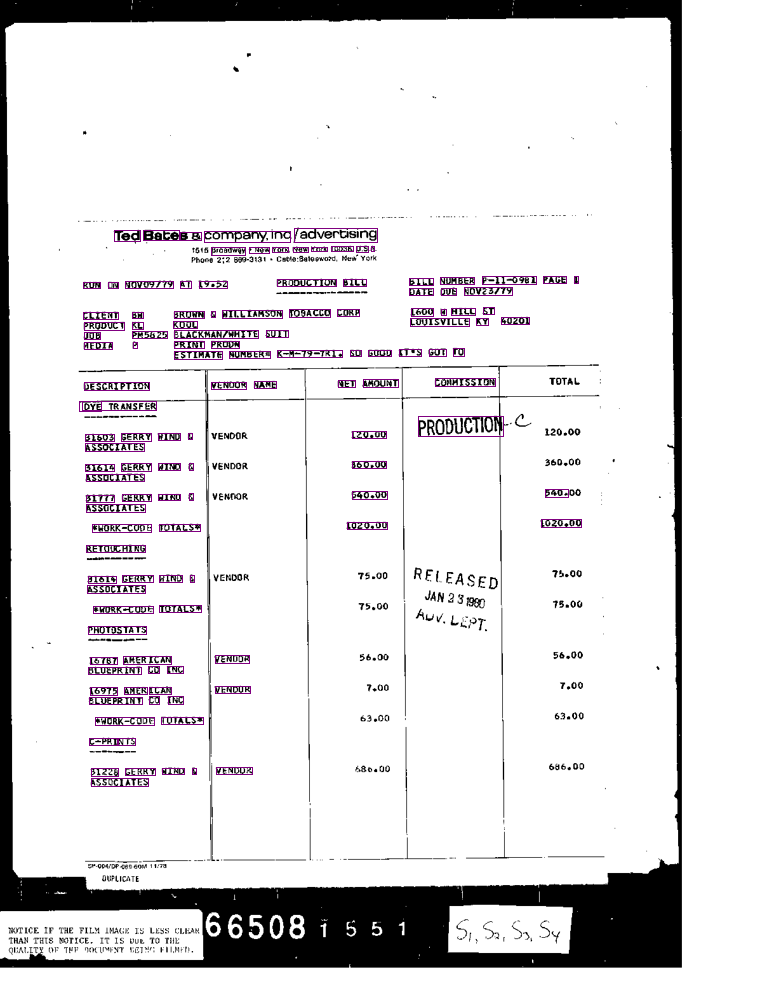

In [ ]:
## Sanity Checking

idx = 5
sample_encoding = ds[idx]

sample_tif_path = df['image_id'].values[idx]
image = Image.open(sample_tif_path).convert("RGB")

image = plot_ocr_on_image(image, sample_encoding['actual_boxes'])
image

2. Decoding
* Works fine

In [ ]:
tokenizer.decode(sample_encoding['input_words'], skip_special_tokens = True)

'Ted Bates a company,inc /advertising Prony «om York ta Yor 0086 US A UN cw NOVOS/79 AT 19452 PRODUCTION BILL CLEENY eW BROWN & MILLEAMSON TOBACCO CoRP praover KL KOOL. Sob prises BLACKMAN/MHETE. SUIT Weora PY PRINT PRODN ESTIMATE MUNBER® K-MT9“TRI. SO GOOD TS GOT TO GILL NUMBER P—i1mo9e2 PAGE 1 DATE QUE ROV23/79 1600 w MILL ST COUISVILUE KY. 40201 bescarprion “Dre TERE 91603 GenaY WIN & Assoezates ‘aes GERRY WIND 6 AssocaaTes 31777 GERRY WHO & AsSocuaTes -swoRx-cone TOTALS® RETOUCHING Biers GEARY MIND & Assocaates ‘swosk-cOve TOTALS® PRoTostaTs e767 AMERICA OUUEPRINT Co TNC 16975 ANER ICA BLUEpRINT C5. TNC ‘swonK-CODe TOTALS* cpm Ts auzze ceRAY MIMD © assoexates, VENOOR WANE eT ANOUNT 120.00 360.00 $40.00 1020.00 venvor vewoor venova comnrsst0% PRODUCTION: 500. 1020.00'

In [ ]:
def collate_fn(list_of_ds):
  encoding = {'input_boxes' : [], 'input_words' : []}

  for i in list_of_ds:
    for key in encoding.keys():
      encoding[key].append(i[key])
    
  for key in encoding.keys():
    encoding[key] = torch.stack(encoding[key], axis = 0)
  return encoding

In [ ]:
class DataModule(pl.LightningDataModule):

  def __init__(self, train_ds, val_ds = None, batch_size : int= 8):

    super().__init__()
    self.train_ds = train_ds
    self.val_ds = val_ds
    self.batch_size = batch_size

  def train_dataloader(self):
    return DataLoader(self.train_ds, batch_size = self.batch_size,
                      shuffle = True, collate_fn = collate_fn,
                      )
    
  def val_dataloader(self):
    if self.val_ds is not None:
      return DataLoader(self.val_ds, batch_size = self.batch_size,
                      shuffle = False, collate_fn = collate_fn,
                      )
    return None

In [ ]:
pl_dl = DataModule(ds)

In [ ]:
sample_encoding = next(iter(pl_dl.train_dataloader()))

In [ ]:
for key in list(sample_encoding.keys()):
  print_statement = '{0: <30}'.format(str(key) + " has a shape:")
  print(print_statement, sample_encoding[key].shape)

input_boxes has a shape:       torch.Size([8, 512, 6])
input_words has a shape:       torch.Size([8, 512])
